In [1]:
# import sys; sys.path.append('/rds/general/user/cb2714/home/wwa'); from wwa import *
import xarray as xr, regionmask, numpy as np, pandas as pd, re, glob, cartopy
import matplotlib, matplotlib.pyplot as plt

varnm = "tx7x"

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/anaconda3/envs/wwa/share/proj failed


In [153]:
! wget https://climexp.knmi.nl/data/era5_tmax_daily_af_extended_20-50E_-10-30N_firstyear-lastyear_su.62f4b5a82fde776a4c64f0ca33646aa0.info_1_max_0_7v.nc

--2025-03-03 11:56:05--  https://climexp.knmi.nl/data/era5_tmax_daily_af_extended_20-50E_-10-30N_firstyear-lastyear_su.62f4b5a82fde776a4c64f0ca33646aa0.info_1_max_0_7v.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4988256 (4.8M) [application/x-netcdf]
Saving to: ‘era5_tmax_daily_af_extended_20-50E_-10-30N_firstyear-lastyear_su.62f4b5a82fde776a4c64f0ca33646aa0.info_1_max_0_7v.nc’

era5_tmax_daily_af_ 100%[===================>]   4.76M  --.-KB/s    in 0.07s   

2025-03-03 11:56:05 (68.0 MB/s) - ‘era5_tmax_daily_af_extended_20-50E_-10-30N_firstyear-lastyear_su.62f4b5a82fde776a4c64f0ca33646aa0.info_1_max_0_7v.nc’ saved [4988256/4988256]



# Flatten gridded data for trend fitting

In [22]:
# load daily data
da = xr.open_dataset("era5_tmax_daily_af_extended_20-50E_-10-30N_firstyear-lastyear_su.62f4b5a82fde776a4c64f0ca33646aa0.info_1_max_0_7v.nc", decode_times = False).max_tmax

# fix time dimension, relabel dates as years
startdate = int(re.sub(".+since ", "", da.time.units)[:4])
da = da.assign_coords(time = [int(t) + startdate for t in da.time]).rename(time = "year")
# da = da.dropna("year", "all")

da = da.sel(year = slice(1970,None))

In [23]:
# mask land only
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)
da = da.where(rm == 0)

# save the map for easier reconstruction later
da.mean("year").to_netcdf("map-tmplt_"+varnm+"_era5.nc")

In [24]:
# flatten & convert to data.frame
df = da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()

# save data.frame as .csv (split into chunks if really large)
ncols = 2500
if df.shape[1] > ncols:
    for i in range(int(np.ceil(df.shape[1] / ncols))):
        df.iloc[:,slice(i*ncols,(i+1)*ncols)].to_csv("flattened/"+varnm+"-flattened_era5_"+str(i+1).rjust(2,"0")+".csv")
else:
    df.to_csv("flattened/"+varnm+"-flattened_era5.csv")

# Load results & reshape dataframe into maps

In [25]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [26]:
# load target map showing original shape of data
tmplt = xr.open_dataset("map-tmplt_"+varnm+"_era5.nc").max_tmax

In [27]:
# load all the flattened results and compile into a single dataframe
df = pd.concat([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("flattened-res/"+varnm+"*.csv"))], axis = 1)

In [28]:
# reconstruct map
res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])

# replace infinite values with very high value
res["PR"] = res.PR.where(np.isfinite(res.PR), 100).where(~np.isnan(res.PR))

In [ ]:
# save
res.to_netcdf("gridded-trend_"+varnm+"_era5.nc")

# Plot results

Text(0.5, 1.0, 'Change in tx7x\nassociated with 1.3C warming')

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


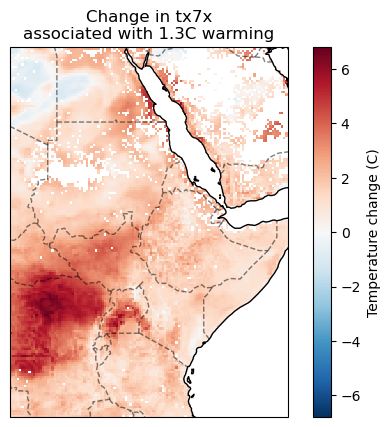

In [31]:
fig = res.dI_abs.plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                     cbar_kwargs = {"label" : "Temperature change (C)"})
ax = fig.axes
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

ax.set_title("Change in "+varnm+"\nassociated with 1.3C warming")

Text(0.5, 1.0, 'Change in tx7x\nassociated with 1.3C warming')

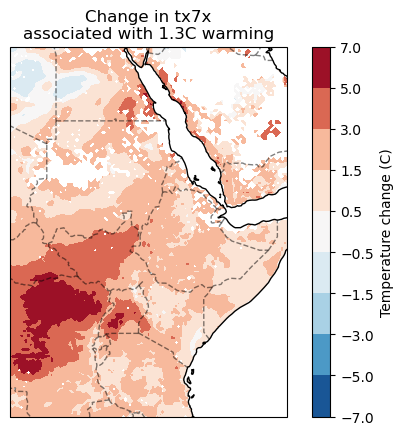

In [33]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

cbar = ax.contourf(res.lon, res.lat, res.dI_abs, cmap = "RdBu_r", levels = [-7,-5,-3,-1.5,-0.5,0.5,1.5,3,5,7])
plt.colorbar(cbar, ax = ax, label = "Temperature change (C)")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

ax.set_title("Change in "+varnm+"\nassociated with 1.3C warming")

Text(0.5, 1.0, 'Return period of 2025 tx7x')

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


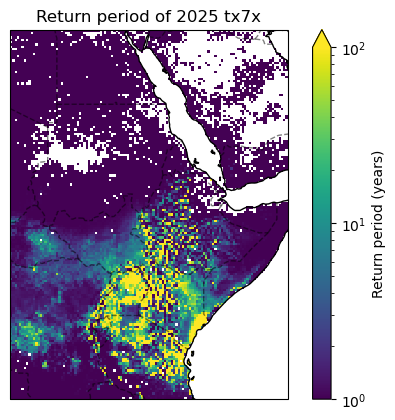

In [35]:
fig = res.return_period.plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                       cbar_kwargs = {"label" : "Return period (years)"},
                       cmap = "viridis", norm = matplotlib.colors.LogNorm(vmin = 1, vmax = 100))
ax = fig.axes
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

ax.set_title("Return period of 2025 "+varnm)

In [ ]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

rp_capped = res.return_period.where(res.return_period < 1000, 1000)
rp_capped = rp_capped.where(~np.isnan(res.return_period))

cbar = ax.contourf(res.lon, res.lat, rp_capped, cmap = "viridis", norm = matplotlib.colors.LogNorm(vmin = 1, vmax = 1000), levels = [1,5,10,25,50,100,500,1000])
plt.colorbar(cbar, ax = ax, label = "Temperature change (C)")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

ax.set_title("Change in "+varnm+"\nassociated with 1.3C warming")

Text(0.5, 1.0, 'Change in tx7x\nassociated with 1.3C warming')